# Final Project Submission

Please fill out:
* Student name: Matt LeRoi
* Student pace: self paced
* Scheduled project review date/time: 10am, Friday, Feb 14, 2025
* Instructor name: Mark Barbour
* Blog post URL: https://github.com/MattLeRoi/dsc-phase-2-project-v3


### Business Understanding

A new movie studio would like input on what sort of films to make. I will present two sets of options, focused on: 1) maximizing the rate of return on their investment and 2) maximizing net profit. The key difference is that
the top 10 films by net profit all had budgets over \\$100M and the top 10 based on rate of return were all $1M and under.

### Data Understanding

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
import sqlite3
import statsmodels.formula.api as smf
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

##### Read the budget.csv file and diplay some basics about it.

The budget file is a list of 5782 films and includes the title, release date, production budget, and the domestic and worldwide grosses for each.

In [2]:
budget = pd.read_csv("./data/tn.movie_budgets.csv.gz")
budget.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [3]:
budget.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


##### Format all of the data appropriately for future use and remove irrelevant rows.

In [4]:
# Convert $ columns to numbers, removing dollar signs and commas.
budget.production_budget = pd.to_numeric(budget.production_budget.str.replace('[$,]',''))
budget.domestic_gross = pd.to_numeric(budget.domestic_gross.str.replace('[$,]',''))
budget.worldwide_gross = pd.to_numeric(budget.worldwide_gross.str.replace('[$,]',''))

In [5]:
# Remove rows that don't have worldwide gross data
budget = budget[budget.worldwide_gross != 0]

In [6]:
# Create columns for release month, release year, profit (based on worldwide gross), 
# and ROI (Return on Investment, as %, i.e.: a ROI of -50% is a loss of half of the 
# production budget, a ROI of 0% is break-even, and a ROI of 75% is a 75% profit)

budget['month']= pd.to_datetime(budget['release_date']).dt.month
budget['year']= pd.to_datetime(budget['release_date']).dt.year
budget['profit'] = budget.worldwide_gross - budget.production_budget
budget['roi'] = 100*budget.profit/budget.production_budget

##### Open the IMDB SQL database and join appropriate tables.

The IMDB SQL database contains various tables with information about films from the years 2010-2019. The details include items like: title, release year, runtime, cast, crew, ratings, etc. The Entity Relationship Diagram is below.

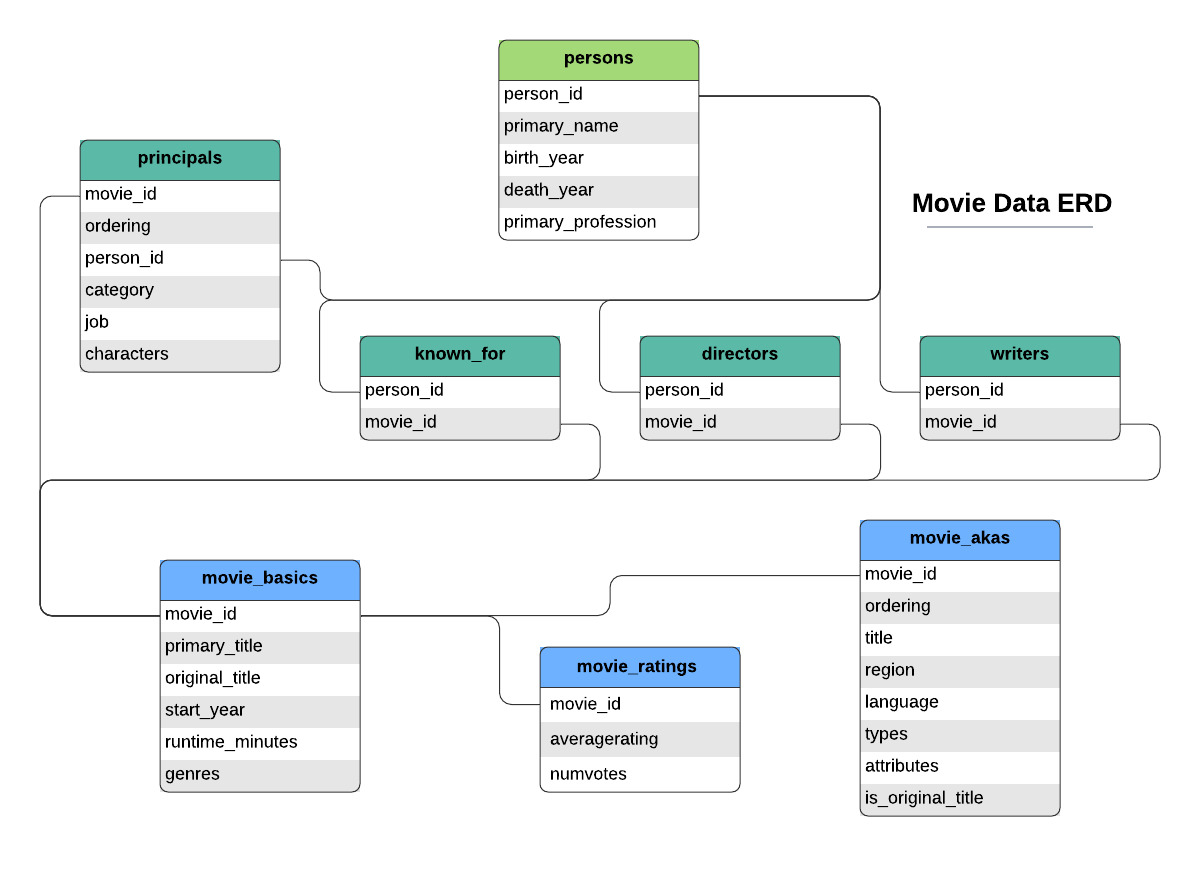

In [7]:
conn = sqlite3.connect("./data/im.db") # Open a connection to IMDB file
cursor = conn.cursor() # Initialize cursor

# SQL query to join movie akas, basics, and ratings tables for further analysis

imdb_query = """SELECT *, movie_akas.movie_id as mv_id
                FROM movie_akas 
                join movie_ratings on movie_akas.movie_id = movie_ratings.movie_id
                join movie_basics on movie_akas.movie_id = movie_basics.movie_id
                ;"""

imdb = pd.read_sql(imdb_query, conn)

# Dropping duplicate movie_id columns (but retaining the mv_id column that I renamed) and redundant "title" column.
imdb.drop(['movie_id','title'],axis = 1, inplace=True)

# Remove redundant rows with same unique identifier (there are redundant rows for the same film being 
# released in different regions)
imdb.drop_duplicates(subset=['mv_id'], inplace=True) 

In [8]:
imdb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69577 entries, 0 to 261803
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ordering           69577 non-null  int64  
 1   region             58133 non-null  object 
 2   language           5706 non-null   object 
 3   types              24182 non-null  object 
 4   attributes         2015 non-null   object 
 5   is_original_title  69577 non-null  float64
 6   averagerating      69577 non-null  float64
 7   numvotes           69577 non-null  int64  
 8   primary_title      69577 non-null  object 
 9   original_title     69577 non-null  object 
 10  start_year         69577 non-null  int64  
 11  runtime_minutes    62830 non-null  float64
 12  genres             68937 non-null  object 
 13  mv_id              69577 non-null  object 
dtypes: float64(3), int64(3), object(8)
memory usage: 8.0+ MB


In [9]:
imdb.head()

,ordering,region,language,types,attributes,is_original_title,averagerating,numvotes,primary_title,original_title,start_year,runtime_minutes,genres,mv_id
0,10,BG,bg,None,None,0.0,7.0,539338,Jurassic World,Jurassic World,2015,124.0,"Action,Adventure,Sci-Fi",tt0369610
48,1,GB,None,None,None,0.0,7.6,23,Cloud Cuckoo Land,Cloud Cuckoo Land,2012,92.0,Drama,tt0381957
49,10,UA,None,None,None,0.0,6.6,241792,John Carter,John Carter,2012,132.0,"Action,Adventure,Sci-Fi",tt0401729
83,1,None,None,original,None,1.0,7.0,5,Versailles Rediscovered - The Sun King's Vanis...,Versailles Rediscovered - The Sun King's Vanis...,2019,52.0,Documentary,tt10010134
86,1,IN,None,None,None,0.0,8.3,30,Vinara sodara veera kumara,Vinara sodara veera kumara,2019,NaN,"Drama,Romance",tt10084780


### Data Preparation

The unique identifier from IMDB doesn't correlate to the budget database, so I will
have to use something else to link the two. The title alone has a significant number of duplicates, so
I'm using the combination of title and year to join the databases. Removing the rows
in which both are duplicated (773 of 6191) is deemed an acceptable loss of data.

In [10]:
# Remove rows where both title and year are duplicated.
imdb.drop_duplicates(subset=['primary_title','start_year'], inplace=True) 

Since the "genres" column has a single entry for each film, often listing several genres, I'm breaking it apart into individual columns to facilitate further analysis. For example, Jurassic World currently lists "Action, Adventure, Sci-Fi" in the genres column. The new Action, Adventure, and Sci-Fi columns will be True for Jurassic World and all other genre columns (thriller, romance, reality-TV, etc.) will be False. In the model, we will see which genres have the greatest effect on profit and ROI, and if certain combinations of genres are more sucessful than others. 

In [11]:
# This will create a list of all of the genres that appear in the IMDB database
genre_list = []
for value in imdb['genres'].str.split(','):
    if value is not None:
        genre_list.extend(value)
genre_list = list(set(genre_list))

# This function will take in a genre name (like "Horror" or "Animation"), create a column in the database for it,
# and populate the column with True or False to show whether that genre applies to each movie.
def add_genre_column (single_genre):
    imdb[single_genre] = imdb['genres'].str.contains(single_genre)

# This loops the genre list and calls the add_genre_column function to add a column and populate it for each genre        
for x in genre_list:
    add_genre_column(x)
    
# Rename columns names with dashes in them to avoid future errors
imdb.rename(columns={'Game-Show': 'Game_Show', 'Reality-TV': 'Reality_TV', 'Sci-Fi' : 'Sci_Fi'}, inplace=True)
genre_list = [g.replace('-', '_') for g in genre_list]

In [12]:
# Set index of each dataframe to the movie title and year, then rename for consistency.

budget.set_index(['movie','year'], inplace=True)
budget.index.rename(['title','year'], inplace=True)

imdb.set_index(['primary_title','start_year'], inplace=True)
imdb.index.rename(['title','year'], inplace=True)

##### Time to join the IMDB and budget dataframes.

In [13]:
imdb_budget = pd.concat([imdb, budget], axis=1, join="inner")

In [14]:
# Adding runtime for those I found manually and removing entries for those I couldn't
imdb_budget.loc['Burlesque','runtime_minutes']=119
imdb_budget.drop(imdb_budget[imdb_budget['original_title'].str.contains('The Promise')].index, inplace=True)

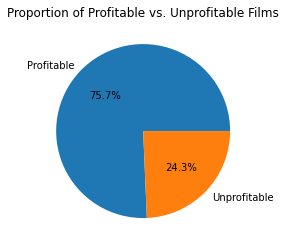

In [15]:
# Creating a pie chart to show the proportion of profitable and unprofitable films. About 3/4 are profitable.
plt.pie([len(imdb_budget[imdb_budget.profit > 0]),len(imdb_budget[imdb_budget.profit < 0])], labels=['Profitable', 'Unprofitable'],autopct='%1.1f%%')
plt.title('Proportion of Profitable vs. Unprofitable Films');

In [16]:
# This function formats the dollar values in future plots to show in millions of dollars, for readability.
# I adapted it for my purposes from here: https://matplotlib.org/3.4.3/gallery/ticks_and_spines/custom_ticker1.html

def millions(x, pos):
    return '${:,.0f}M'.format(x*1e-6)

''

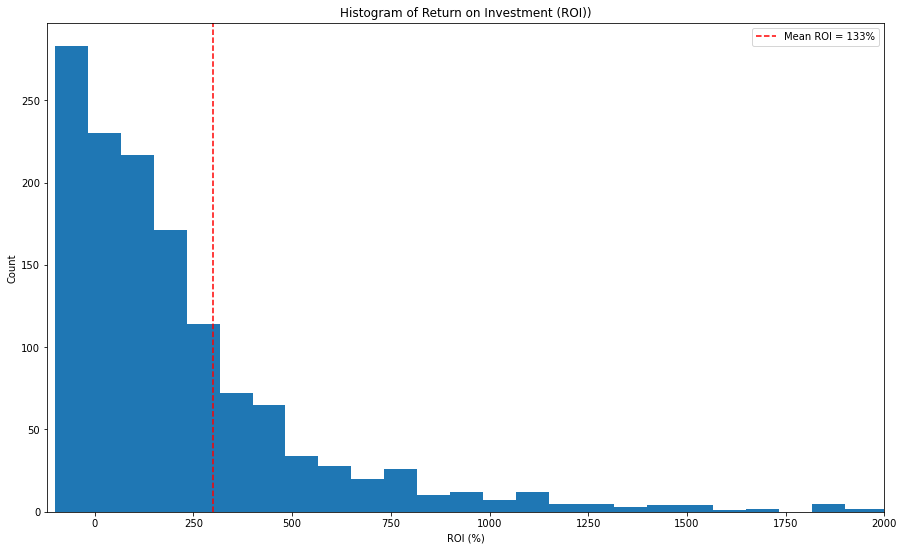

In [17]:
fig, ax = plt.subplots(figsize=(15,9))
plt.hist(imdb_budget.roi, bins=500)

ax.set_title('Histogram of Return on Investment (ROI))')
ax.set_xlabel('ROI (%)')
ax.set_ylabel('Count')
ax.set_xlim([-120, 2000]) # There are outliers at 10,000% and 40,000% that make the whole chart hard to read at full scale.
plt.axvline(x=imdb_budget.roi.mean(), color='r', linestyle='--', label = 'Mean ROI = 133%')
plt.legend()
;

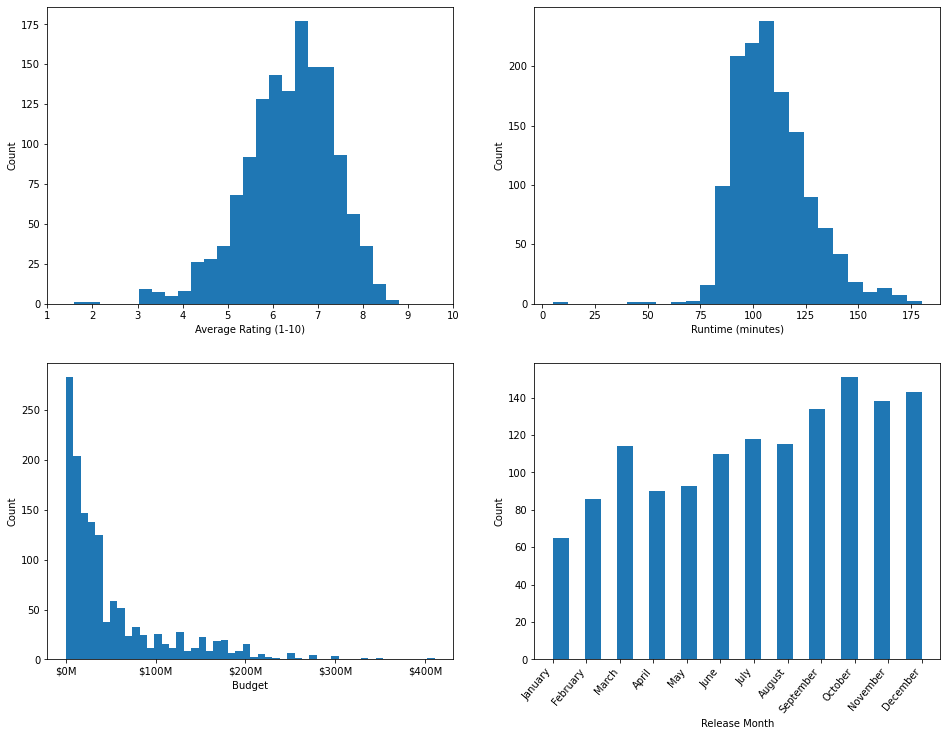

In [18]:
fig, axs = plt.subplots(2,2, figsize=(16,12))
axs[0, 0].hist(imdb_budget.averagerating, bins=25)
axs[0, 0].set_xlabel('Average Rating (1-10)')
axs[0, 0].set_xticks(range(1, 11, 1))
axs[0, 1].hist(imdb_budget.runtime_minutes, bins=25)
axs[0, 1].set_xlabel('Runtime (minutes)')
axs[1, 0].hist(imdb_budget.production_budget, bins=50)
axs[1, 0].set_xlabel('Budget')
axs[1, 0].xaxis.set_major_formatter(millions)
axs[1, 1].hist(imdb_budget.month, bins=23)
axs[1, 1].set_xlabel('Release Month')
axs[1, 1].set_xticks(range(1, 13, 1))
axs[1, 1].set_xticklabels(['January','February','March','April','May','June','July','August','September','October','November','December'], ha='right')

for ax in axs.flat:
    ax.set(ylabel='Count')
    
for tick in axs[1, 1].get_xticklabels():
    tick.set_rotation(50)

''

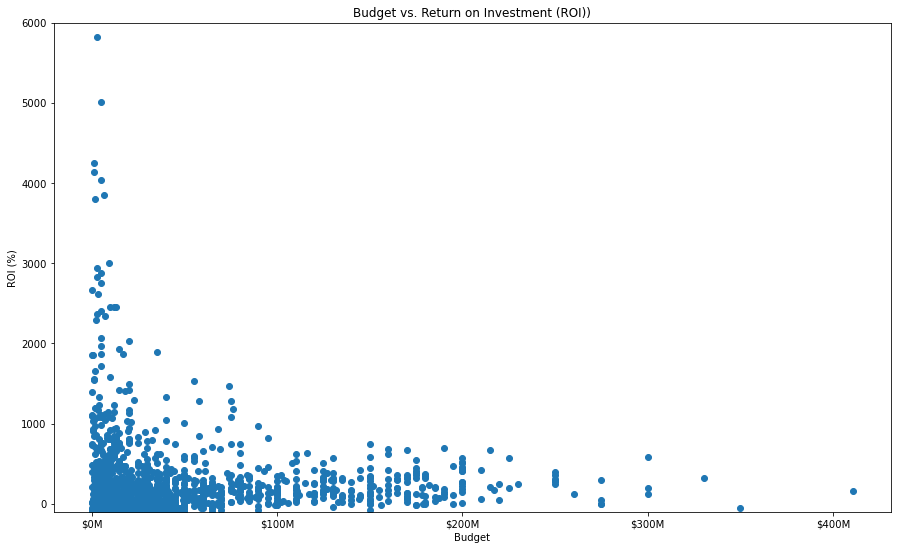

In [19]:
fig, ax = plt.subplots(figsize=(15,9))
plt.scatter(imdb_budget.production_budget,imdb_budget.roi)

ax.set_title('Budget vs. Return on Investment (ROI))')
ax.set_xlabel("Budget")
ax.set_ylabel("ROI (%)")
ax.set_ylim([-100, 6000]) # Limited again for visibility.
ax.xaxis.set_major_formatter(millions)
;

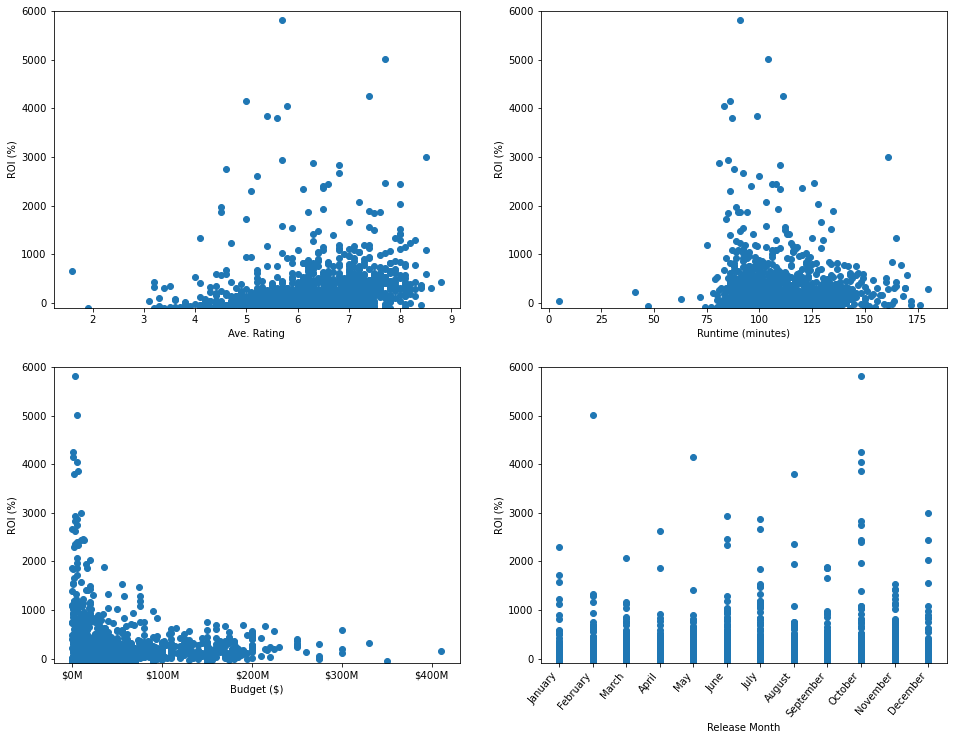

In [20]:
fig, axs = plt.subplots(2,2, figsize=(16,12))
axs[0, 0].scatter(imdb_budget.averagerating,imdb_budget.roi)
axs[0, 0].set_xlabel('Ave. Rating')
axs[0, 1].scatter(imdb_budget.runtime_minutes,imdb_budget.roi)
axs[0, 1].set_xlabel('Runtime (minutes)')
axs[1, 0].scatter(imdb_budget.production_budget,imdb_budget.roi)
axs[1, 0].set_xlabel('Budget ($)')
axs[1, 0].xaxis.set_major_formatter(millions)
axs[1, 1].scatter(imdb_budget.month,imdb_budget.roi)
axs[1, 1].set_xlabel('Release Month')
axs[1, 1].set_xticks(range(1, 13, 1))
axs[1, 1].set_xticklabels(['January','February','March','April','May','June','July','August','September','October','November','December'], ha='right')

for ax in axs.flat:
    ax.set(ylabel='ROI (%)')
    ax.set(ylim=[-100,6000]) # Limited again for visibility.
    
for tick in axs[1, 1].get_xticklabels():
    tick.set_rotation(50)

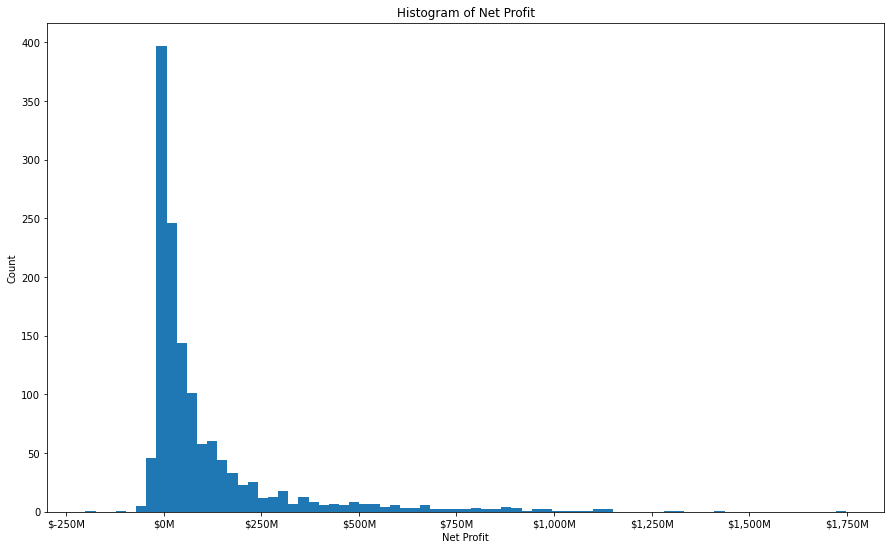

In [21]:
fig, ax = plt.subplots(figsize=(15,9))
plt.hist(imdb_budget.profit, bins=75)

ax.set_title('Histogram of Net Profit')
ax.set_xlabel('Net Profit')
ax.set_ylabel('Count')
ax.xaxis.set_major_formatter(millions);

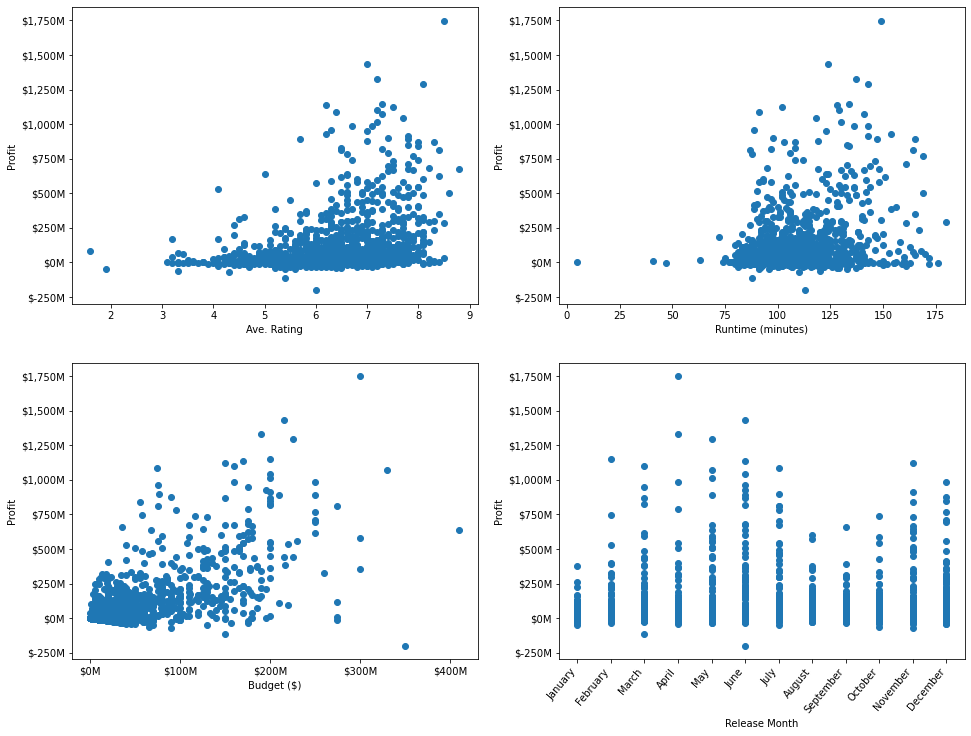

In [22]:
fig, axs = plt.subplots(2,2, figsize=(16,12))
axs[0, 0].scatter(imdb_budget.averagerating,imdb_budget.profit)
axs[0, 0].set_xlabel('Ave. Rating')
axs[0, 1].scatter(imdb_budget.runtime_minutes,imdb_budget.profit)
axs[0, 1].set_xlabel('Runtime (minutes)')
axs[1, 0].scatter(imdb_budget.production_budget,imdb_budget.profit)
axs[1, 0].set_xlabel('Budget ($)')
axs[1, 0].xaxis.set_major_formatter(millions)
axs[1, 1].scatter(imdb_budget.month,imdb_budget.profit)
axs[1, 1].set_xlabel('Release Month')
axs[1, 1].set_xticks(range(1, 13, 1))
axs[1, 1].set_xticklabels(['January','February','March','April','May','June','July','August','September','October','November','December'], ha='right')

for ax in axs.flat:
    ax.set(ylabel='Profit')
    ax.yaxis.set_major_formatter(millions)
    
for tick in axs[1, 1].get_xticklabels():
    tick.set_rotation(50)

I am binning the runtime to create categories. Where I think it is reasonable to include rating as a continuous variable where there may be a general upward trend that shows higher rated films are more successful, I don't expect a linear relationship showing that longer movies are generally more or less successful in proportion to their length. I expected that particularly long or particularly short movies would be less successful with a generally bell-shaped curve and, very broadly speaking, it appears this may be true, with the peak seen at around 150 minutes.

In [23]:
imdb_budget['runtime_cat'] = pd.cut(x=imdb_budget['runtime_minutes'], bins=[-1,0,75,90,105,120,135,150,9999],
                            labels=['neg','<75','75-90','90-105','105-120','120-135','135-150','150+'])

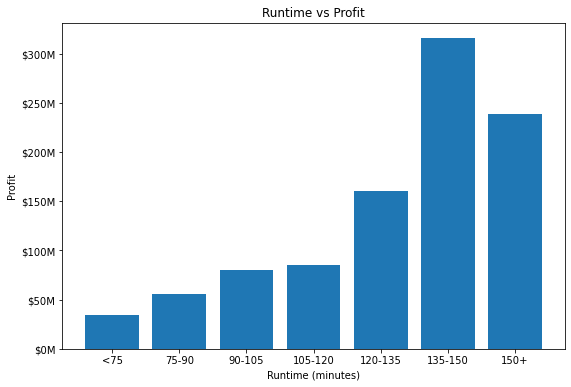

In [24]:
runtime_cat_vs_profit=imdb_budget.groupby('runtime_cat')['profit'].mean()
x = runtime_cat_vs_profit.index
y = runtime_cat_vs_profit

fig, ax = plt.subplots(figsize = (9,6))
ax.bar(x,y)
ax.set_title('Runtime vs Profit')
ax.yaxis.set_major_formatter(millions)
ax.set_xlabel('Runtime (minutes)')
ax.set_ylabel('Profit');

### Modeling

This will create the model for return on investment vs. genre, runtime, rating, and budget.

In [25]:
# Creating a new genre list that includes only genres that appear in the combined imdb/budget dataframe.
imdb_budget_genre_list = []
for value in imdb_budget['genres'].str.split(','):
    if value is not None:
        imdb_budget_genre_list.extend(value)
imdb_budget_genre_list = list(set(imdb_budget_genre_list))
imdb_budget_genre_list = [g.replace('-', '_') for g in imdb_budget_genre_list]

#### Create the model for ROI

In [26]:
# Using the imdb_budget_genre_list to populate the formula for the model, with ROI as the dependent variable.
# Note that month is listed as a category although it is a number.
genre_string_for_formula = ') + C('.join([str(g) for g in imdb_budget_genre_list])
formula = 'roi ~ C('+genre_string_for_formula+')'+ '+ C(runtime_cat) + averagerating + production_budget + C(month)'
lm = smf.ols(formula, imdb_budget).fit()
roi_model_table = lm.summary2().tables[1]
roi_model_table[roi_model_table['P>|t|'] <= 0.05].sort_values('P>|t|')

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
C(Horror)[T.True],509.841891,135.111538,3.773489,0.000168,244.784365,774.899418
C(Mystery)[T.True],420.182307,136.210256,3.084807,0.002079,152.969352,687.395262
averagerating,95.855075,40.742966,2.352678,0.018785,15.926817,175.783332
C(runtime_cat)[T.75-90],261.964992,120.337240,2.176924,0.029664,25.891216,498.038769


#### Create the model for profit.

In [27]:
# Using the same code again to populate the formula for the profit model (with ROI changed to profit).
genre_string_for_formula = ') + C('.join([str(g) for g in imdb_budget_genre_list])
formula = 'profit ~ C('+genre_string_for_formula+')'+ '+ C(runtime_cat) + averagerating + production_budget + C(month)'
lm = smf.ols(formula, imdb_budget).fit()
profit_model_table = lm.summary2().tables[1]
profit_model_table[profit_model_table['P>|t|'] <= 0.05].sort_values('P>|t|')

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
production_budget,1.794967e+00,1.066485e-01,16.830684,1.014056e-57,1.585748e+00,2.004187e+00
averagerating,4.639612e+07,4.674129e+06,9.926154,1.924542e-22,3.722657e+07,5.556568e+07
Intercept,-2.264469e+08,3.292969e+07,-6.876678,9.440503e-12,-2.910473e+08,-1.618465e+08
C(runtime_cat)[T.105-120],-5.525923e+07,1.158583e+07,-4.769553,2.052037e-06,-7.798794e+07,-3.253051e+07
C(runtime_cat)[T.90-105],-4.704354e+07,1.105610e+07,-4.254985,2.238645e-05,-6.873305e+07,-2.535403e+07
C(Animation)[T.True],6.653289e+07,1.919894e+07,3.465445,5.463836e-04,2.886901e+07,1.041968e+08
C(Drama)[T.True],-3.745442e+07,1.152312e+07,-3.250371,1.181705e-03,-6.006012e+07,-1.484872e+07
C(Sci_Fi)[T.True],4.718515e+07,1.580905e+07,2.984692,2.891021e-03,1.617146e+07,7.819885e+07
C(runtime_cat)[T.75-90],-3.735014e+07,1.380537e+07,-2.705479,6.908655e-03,-6.443308e+07,-1.026721e+07
C(runtime_cat)[T.120-135],-3.360481e+07,1.396043e+07,-2.407148,1.621466e-02,-6.099194e+07,-6.217687e+06


The statistically significant factors are: production budget, average rating, runtimes > 90 min, and the genres horror, sci-fi, drama, animation, and thriller. Of those, the following have positive effects on profit: production budget, rating, animation, sci-fi, runtime, horror, and thriller. Dramas are negatively correlated with profit.

In [70]:
# Create table of mean ROI, profit, and worldwide gross for each genre, plus the overall mean for all films.

genre_means = pd.DataFrame([(g, imdb_budget['production_budget'][imdb_budget[g]==True].mean(),
                             imdb_budget['roi'][imdb_budget[g]==True].mean(), 
                             imdb_budget['profit'][imdb_budget[g]==True].mean(), 
                             imdb_budget['worldwide_gross'][imdb_budget[g]==True].mean()) 
                            for g in imdb_budget_genre_list], columns=['genre','budget','mean_roi','mean_profit', 'mean_ww_gross'])

# Add a line for the overall averages for comparison
overall = {'genre': 'Overall', 
          'budget' : imdb_budget['production_budget'].mean(),
          'mean_roi': imdb_budget['roi'].mean(), 
          'mean_profit': imdb_budget['profit'].mean(), 
          'mean_ww_gross': imdb_budget['worldwide_gross'].mean()}
genre_means = genre_means.append(overall, ignore_index=True)

# Create subsets of statistically significant genres for ROI and profit, plus overall
top_roi = genre_means.sort_values('mean_roi', ascending=False).head(2).append(overall, ignore_index=True)
top_profit = genre_means[genre_means.genre.isin(['Animation', 'Drama', 'Sci_Fi', 'Thriller'])].sort_values('mean_profit', ascending=False).append(overall, ignore_index=True)

In [29]:
top_profit

,genre,budget,mean_roi,mean_profit,mean_ww_gross
0,Animation,1.001939e+08,278.690125,2.885616e+08,3.887555e+08
1,Sci_Fi,1.002206e+08,284.919637,2.670834e+08,3.673040e+08
2,Thriller,3.568454e+07,598.186551,9.246756e+07,1.281521e+08
3,Drama,2.831032e+07,239.786746,5.072263e+07,7.903295e+07
4,Overall,4.821342e+07,298.775147,1.060221e+08,1.542355e+08


In [30]:
top_roi

,genre,budget,mean_roi,mean_profit,mean_ww_gross
0,Horror,1.983247e+07,959.933922,5.887476e+07,7.870723e+07
1,Mystery,2.605498e+07,944.029296,7.069490e+07,9.674988e+07
2,Overall,4.821342e+07,298.775147,1.060221e+08,1.542355e+08


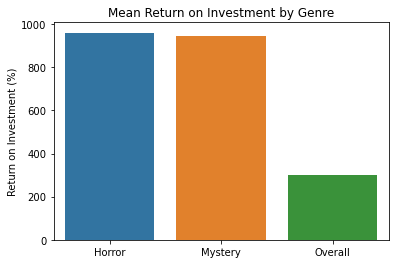

In [31]:
ax=sns.barplot(x=top_roi['genre'],y=top_roi['mean_roi'])
plt.title('Mean Return on Investment by Genre')
plt.xlabel('')
plt.ylabel('Return on Investment (%)');

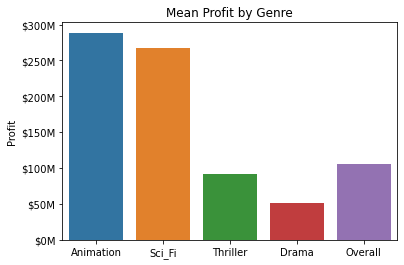

In [32]:
ax=sns.barplot(x=top_profit['genre'],y=top_profit['mean_profit'])
plt.title('Mean Profit by Genre')
plt.xlabel('')
plt.ylabel('Profit')
ax.yaxis.set_major_formatter(millions);

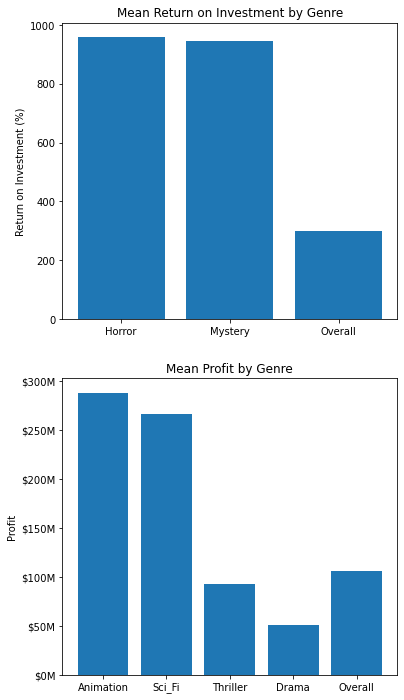

In [33]:
x=top_roi['genre']
y=top_roi['mean_roi']
fig, axs = plt.subplots(2, figsize=(6,12))
axs[0].bar(top_roi['genre'], top_roi['mean_roi'])
axs[0].set_title('Mean Return on Investment by Genre')
axs[0].set_ylabel('Return on Investment (%)')
axs[1].bar(top_profit['genre'], top_profit['mean_profit'])
axs[1].set_title('Mean Profit by Genre')
axs[1].yaxis.set_major_formatter(millions)
axs[1].set_ylabel('Profit');

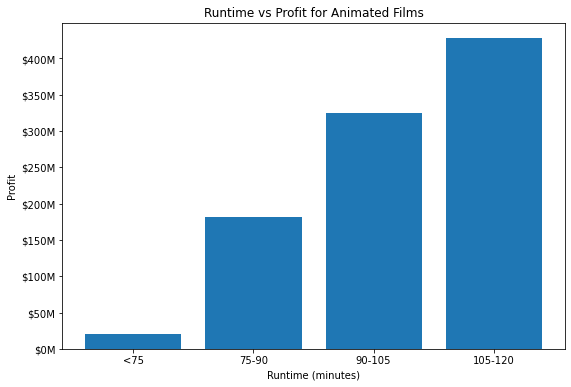

In [34]:
anim_runtime_cat_vs_profit=imdb_budget[imdb_budget.Animation == True].groupby('runtime_cat')['profit'].mean()
x = anim_runtime_cat_vs_profit.index
y = anim_runtime_cat_vs_profit

fig, ax = plt.subplots(figsize = (9,6))
ax.bar(x,y)
ax.set_title('Runtime vs Profit for Animated Films')
ax.yaxis.set_major_formatter(millions)
ax.set_xlabel('Runtime (minutes)')
ax.set_ylabel('Profit');

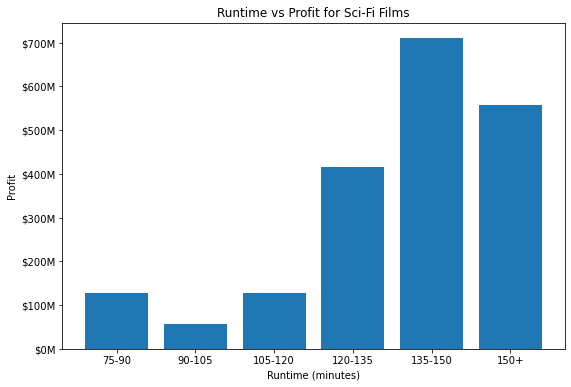

In [35]:
scifi_runtime_cat_vs_profit=imdb_budget[imdb_budget.Sci_Fi == True].groupby('runtime_cat')['profit'].mean()
x = scifi_runtime_cat_vs_profit.index
y = scifi_runtime_cat_vs_profit

fig, ax = plt.subplots(figsize = (9,6))
ax.bar(x,y)
ax.set_title('Runtime vs Profit for Sci-Fi Films')
ax.yaxis.set_major_formatter(millions)
ax.set_xlabel('Runtime (minutes)')
ax.set_ylabel('Profit');

The genre_combos function will help understand the effects of combining genres. It inputs a single genre and creates a table with the mean budget, ROI, profit, and worldwide gross for each genre that is paired with it. For example, inputing Horror creates a table that shows that combining Mystery with Horror has a particulary high ROI while combining Family or Romance with Horror is generally less successful. Also note that within the Horror table, the row indexed as Horror contains the overall averages for all films that list Horror as a genre, either alone or combined with any other combination of genres.

In [36]:
def genre_combos(main_genre):
    
    all_main_genre = imdb_budget[imdb_budget[main_genre]==True]
    main_genre_means = pd.DataFrame([(g, all_main_genre['production_budget'][all_main_genre[g]==True].mean(),
                                 all_main_genre['roi'][all_main_genre[g]==True].mean(), 
                                 all_main_genre['profit'][all_main_genre[g]==True].mean(), 
                                 all_main_genre['worldwide_gross'][all_main_genre[g]==True].mean()) 
                                for g in imdb_budget_genre_list], columns=['genre','budget','mean_roi','mean_profit', 'mean_ww_gross'])
    main_genre_means.dropna(inplace=True)
    
    return main_genre_means.sort_values('mean_roi', ascending=False)

horror_means = genre_combos('Horror')
horror_means

,genre,budget,mean_roi,mean_profit,mean_ww_gross
9,Mystery,1.175361e+07,1829.866821,7.215167e+07,8.390528e+07
16,Thriller,1.240040e+07,1696.796697,7.922419e+07,9.162459e+07
12,Horror,1.983247e+07,959.933922,5.887476e+07,7.870723e+07
3,Drama,1.817244e+07,455.375358,3.839690e+07,5.656934e+07
20,Sci_Fi,3.316667e+07,393.294086,7.627897e+07,1.094456e+08
0,Crime,1.308000e+07,349.261721,2.981656e+07,4.289656e+07
7,Action,4.421818e+07,210.003109,7.930668e+07,1.235249e+08
1,Adventure,4.561250e+07,158.286001,7.824883e+07,1.238613e+08
15,Fantasy,3.890238e+07,129.548461,3.352697e+07,7.242935e+07
14,Comedy,2.714000e+07,109.675351,1.679593e+07,4.393593e+07


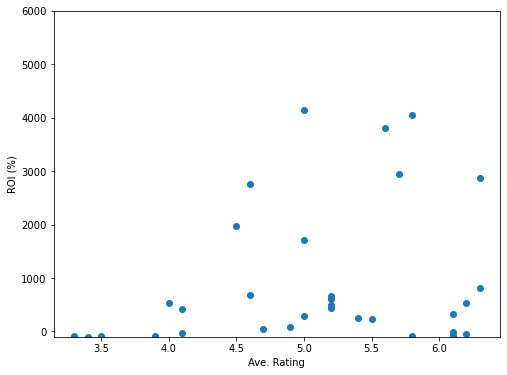

In [37]:
fig, ax = plt.subplots(figsize=(8,6))
x = imdb_budget[(imdb_budget.Horror == True) & (imdb_budget.runtime_minutes > 75) & (imdb_budget.runtime_minutes < 90)].averagerating
y = imdb_budget[(imdb_budget.Horror == True) & (imdb_budget.runtime_minutes > 75) & (imdb_budget.runtime_minutes < 90)].roi
ax.scatter(x,y)
ax.set_xlabel('Ave. Rating')
ax.set_ylabel('ROI (%)')
ax.set(ylim=[-100,6000]);

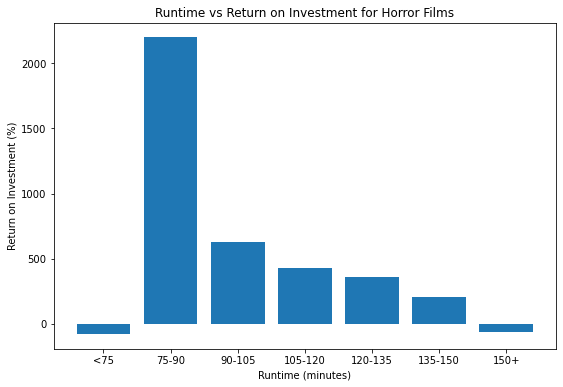

In [38]:
horror_runtime_cat_vs_roi=imdb_budget[imdb_budget.Horror == True].groupby('runtime_cat')['roi'].mean()
x = horror_runtime_cat_vs_roi.index
y = horror_runtime_cat_vs_roi

fig, ax = plt.subplots(figsize = (9,6))
ax.bar(x,y)
ax.set_title('Runtime vs Return on Investment for Horror Films')
ax.set_xlabel('Runtime (minutes)')
ax.set_ylabel('Return on Investment (%)');

The statistically significant factors shown above, with an alpha of 0.05, narrow down the parameters to two genres, Horror and Mystery, with a runtime of 75-90 minutes.

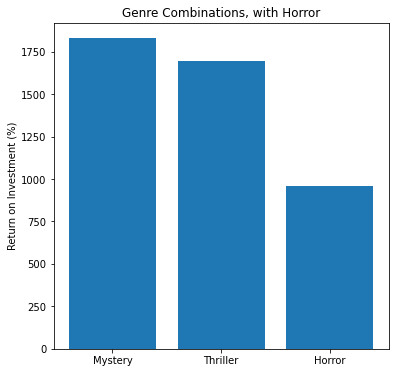

In [39]:
x = horror_means.genre.head(3)
y = horror_means.mean_roi.head(3)

fig, ax = plt.subplots(figsize = (6,6))
ax.bar(x,y)
ax.set_title('Genre Combinations, with Horror')
ax.set_ylabel('Return on Investment (%)');

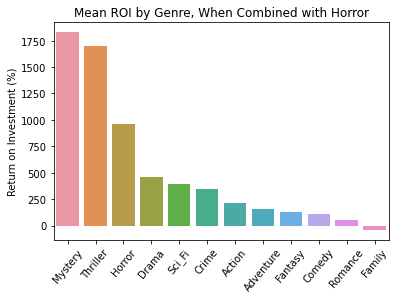

In [72]:
ax=sns.barplot(x = horror_means.genre, y = horror_means.mean_roi)
plt.title('Mean ROI by Genre, When Combined with Horror')
plt.xlabel('')
plt.ylabel('Return on Investment (%)')
for tick in ax.get_xticklabels():
    tick.set_rotation(50);

In [41]:
mystery_means = genre_combos('Mystery')
mystery_means

,genre,budget,mean_roi,mean_profit,mean_ww_gross
12,Horror,1.175361e+07,1829.866821,7.215167e+07,8.390528e+07
16,Thriller,2.118554e+07,1791.001058,9.540731e+07,1.165928e+08
9,Mystery,2.605498e+07,944.029296,7.069490e+07,9.674988e+07
14,Comedy,2.154000e+07,327.115100,1.156889e+08,1.372289e+08
1,Adventure,8.500000e+07,313.162073,1.480358e+08,2.330358e+08
3,Drama,2.651430e+07,283.800390,4.057901e+07,6.709331e+07
20,Sci_Fi,4.114286e+07,248.287380,8.599010e+07,1.271330e+08
7,Action,6.107692e+07,190.605430,9.660330e+07,1.576802e+08
0,Crime,3.246800e+07,160.496433,4.641682e+07,7.888482e+07
4,War,6.800000e+06,135.857985,9.238343e+06,1.603834e+07


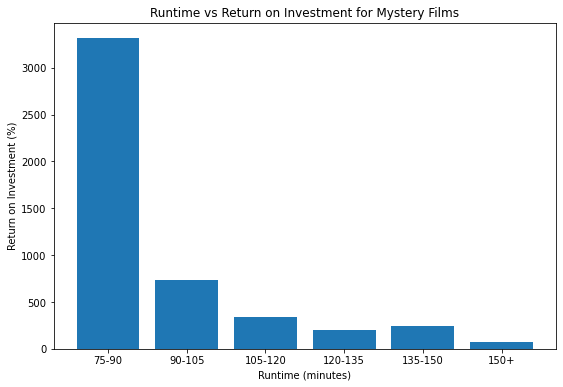

In [42]:
myst_runtime_cat_vs_roi=imdb_budget[imdb_budget.Mystery == True].groupby('runtime_cat')['roi'].mean()
x = myst_runtime_cat_vs_roi.index
y = myst_runtime_cat_vs_roi

fig, ax = plt.subplots(figsize = (9,6))
ax.bar(x,y)
ax.set_title('Runtime vs Return on Investment for Mystery Films')
ax.set_xlabel('Runtime (minutes)')
ax.set_ylabel('Return on Investment (%)');

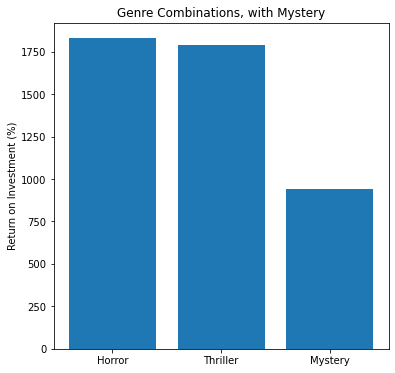

In [43]:
x = mystery_means.genre.head(3)
y = mystery_means.mean_roi.head(3)

fig, ax = plt.subplots(figsize = (6,6))
ax.bar(x,y)
ax.set_title('Genre Combinations, with Mystery')
ax.set_ylabel('Return on Investment (%)');

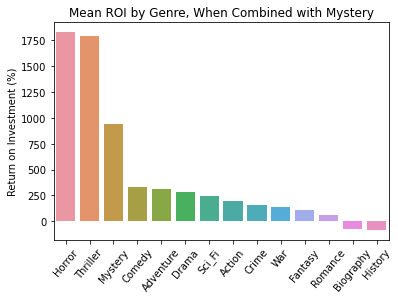

In [74]:
ax=sns.barplot(x = mystery_means.genre, y = mystery_means.mean_roi)
plt.title('Mean ROI by Genre, When Combined with Mystery')
plt.xlabel('')
plt.ylabel('Return on Investment (%)')
for tick in ax.get_xticklabels():
    tick.set_rotation(50);

In [45]:
# This repeats the above approach to look at genre combinations vs profit.
def genre_combos_profit(main_genre):
    
    all_main_genre = imdb_budget[imdb_budget[main_genre]==True]
    main_genre_means = pd.DataFrame([(g, all_main_genre['production_budget'][all_main_genre[g]==True].mean(),
                                 all_main_genre['roi'][all_main_genre[g]==True].mean(), 
                                 all_main_genre['profit'][all_main_genre[g]==True].mean(), 
                                 all_main_genre['worldwide_gross'][all_main_genre[g]==True].mean()) 
                                for g in imdb_budget_genre_list], columns=['genre','budget','mean_roi','mean_profit', 'mean_ww_gross'])
    main_genre_means.dropna(inplace=True)
 
    return main_genre_means.sort_values('mean_profit', ascending=False)

animation_means = genre_combos_profit('Animation')
animation_means

,genre,budget,mean_roi,mean_profit,mean_ww_gross
7,Action,1.142500e+08,248.862486,3.069505e+08,4.212005e+08
1,Adventure,1.045632e+08,276.030407,2.962842e+08,4.008474e+08
14,Comedy,9.753205e+07,298.556991,2.929458e+08,3.904779e+08
19,Animation,1.001939e+08,278.690125,2.885616e+08,3.887555e+08
10,Family,6.405000e+07,237.259701,1.794857e+08,2.435357e+08
3,Drama,8.000000e+06,-28.672900,-2.293832e+06,5.706168e+06


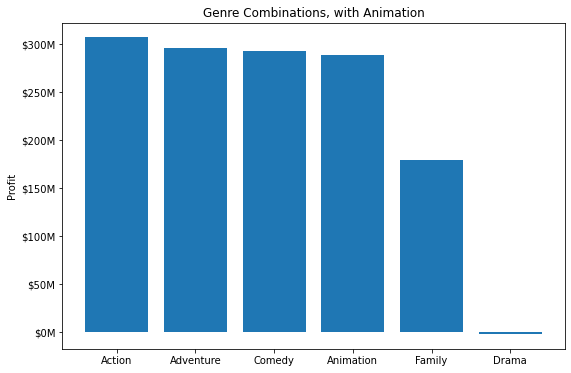

In [46]:
x = animation_means.genre
y = animation_means.mean_profit

fig, ax = plt.subplots(figsize = (9,6))
ax.bar(x,y)
ax.set_title('Genre Combinations, with Animation')
ax.yaxis.set_major_formatter(millions)
ax.set_ylabel('Profit');

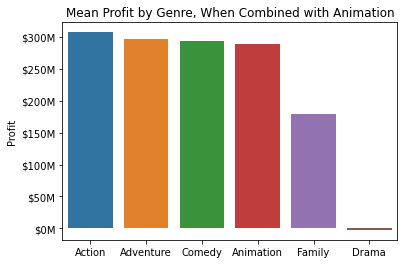

In [47]:
ax=sns.barplot(x = animation_means.genre.head(6), y = animation_means.mean_profit.head(6))
plt.title('Mean Profit by Genre, When Combined with Animation')
plt.xlabel('')
plt.ylabel('Profit')
ax.yaxis.set_major_formatter(millions);

In [48]:
scifi_means = genre_combos_profit('Sci_Fi')
scifi_means

,genre,budget,mean_roi,mean_profit,mean_ww_gross
1,Adventure,1.660386e+08,274.248053,4.668479e+08,6.328865e+08
7,Action,1.298583e+08,282.462587,3.527055e+08,4.825638e+08
20,Sci_Fi,1.002206e+08,284.919637,2.670834e+08,3.673040e+08
16,Thriller,4.160476e+07,409.345288,1.486035e+08,1.902082e+08
3,Drama,5.538190e+07,324.308572,1.353754e+08,1.907573e+08
9,Mystery,4.114286e+07,248.287380,8.599010e+07,1.271330e+08
12,Horror,3.316667e+07,393.294086,7.627897e+07,1.094456e+08
8,Romance,3.356250e+07,259.182459,5.141085e+07,8.497335e+07
10,Family,1.300000e+07,224.419577,2.917454e+07,4.217454e+07
14,Comedy,3.080000e+07,96.221035,2.771306e+07,5.851306e+07


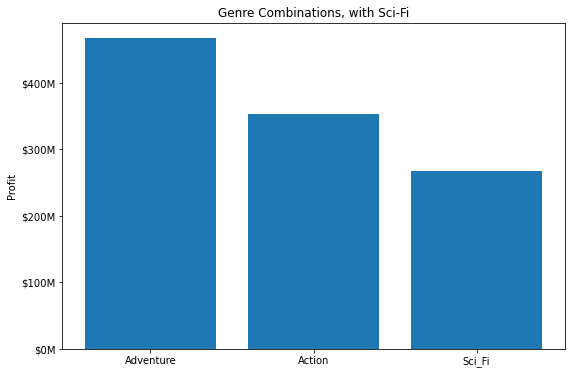

In [49]:
x = scifi_means.genre.head(3)
y = scifi_means.mean_profit.head(3)

fig, ax = plt.subplots(figsize = (9,6))
ax.bar(x,y)
ax.set_title('Genre Combinations, with Sci-Fi')
ax.yaxis.set_major_formatter(millions)
ax.set_ylabel('Profit');

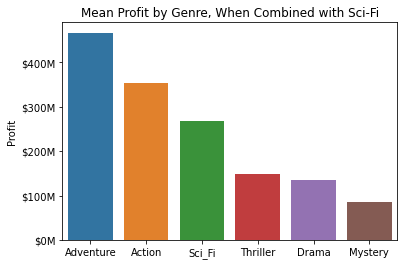

In [50]:
ax=sns.barplot(x = scifi_means.genre.head(6), y = scifi_means.mean_profit.head(6))
plt.title('Mean Profit by Genre, When Combined with Sci-Fi')
plt.xlabel('')
plt.ylabel('Profit')
ax.yaxis.set_major_formatter(millions);

### Evaluation

### Deployment

In [51]:
# budget.drop_duplicates(subset=['movie','year'],, keep=False inplace=True)
# budget[budget.movie.duplicated(keep=False)].sort_values('movie')

In [52]:
# There is one duplicate movie title. I will 

# budget.drop_duplicates(subset=['movie','year'], inplace=True)
# budget

In [53]:
# imdb[imdb['primary_title'].str.contains( 'The Promise')]
# # budget.reset_index(inplace=True)
# # budget[budget['title'].str.contains( 'The Promise')]

In [54]:
# budget[budget.index.duplicated(keep=False)].sort_values('movie').head(50)

In [55]:
# imdb.reset_index(inplace=True)
# imdb.drop_duplicates(subset=['title','year'], keep=False)


# budget[budget.index.duplicated(keep=False)]

In [56]:
# gross[gross.index.duplicated(keep=False)].sort_values('title').head(50)
# gross.drop_duplicates(subset='title', inplace=True)

In [57]:
# gross=pd.read_csv("./data/bom.movie_gross.csv.gz")
# gross.info()

In [58]:
# gross.head()

In [59]:
# # Convert foreign gross to a number
# gross['foreign_gross'] = pd.to_numeric(gross.foreign_gross.str.replace('[,]',''))

# #Foreign gross over $1 billion is listed in millions (verified by comparing this database to the budget database)
# gross.loc[gross[gross['title']=='The Fate of the Furious'].index,'foreign_gross'] = 1010*1000000
# gross.loc[gross[gross['title']=='Jurassic World'].index,'foreign_gross'] = 1019.4*1000000
# gross.loc[gross[gross['title']=='Star Wars: The Force Awakens'].index,'foreign_gross'] = 1131.6*1000000
# gross.loc[gross[gross['title']=='Furious 7'].index,'foreign_gross'] = 1163*1000000
# gross.loc[gross[gross['title']=='Avengers: Infinity War'].index,'foreign_gross'] = 1369.5*1000000
# gross.fillna(0, inplace=True)

# gross['worldwide_gross'] = gross.domestic_gross + gross.foreign_gross
# gross.set_index(['title','year'], inplace=True)
# imdb_gross = pd.concat([imdb, gross], axis=1, join="inner")

In [60]:
# budget.sort_values('roi').tail(10)

In [61]:
# imdb_budget.sort_values('year').head(10)

In [62]:
# imdb.reset_index(inplace=True)
# imdb.loc[imdb['title'].str.contains('Super Size')]
# imdb.value_counts('year')


In [63]:
# X=imdb_budget[['production_budget']]
# y=imdb_budget.roi

# # Create an OLS model
# model = sm.OLS(endog=y, exog=sm.add_constant(X))

In [64]:
# # Get model results
# results = model.fit()
# # Display results summary
# results.summary()

In [65]:
# # Plot the model fit (scatter plot and regression line)
# sns.regplot(x="production_budget",y="roi",data=imdb_budget);

In [66]:
# X=imdb_budget[['production_budget','averagerating', 'runtime_minutes']]
# y=imdb_budget.roi

# # Create an OLS model
# model = sm.OLS(endog=y, exog=sm.add_constant(X))

In [67]:
# # Get model results
# results = model.fit()
# # Display results summary
# results.summary()

In [68]:
# table = sm.stats.anova_lm(lm, typ=2)
# table.sort_values('PR(>F)', inplace=True, ascending=True)
# print(table)